In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from models_tf import Sampler, NN, NN_FF, NN_mFF

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
np.random.seed(1232)
tf.set_random_seed(1232)

In [3]:
if __name__ == '__main__':

    # Hyper-parameters
    a = 4
    b = 150

    # Exact solution
    def u(x, a, b):
        return np.sin(np.pi * a * x) + 0.1 * np.sin(np.pi * b * x)

    # Exact PDE residual
    def u_xx(x, a, b):
        return - (np.pi * a) ** 2 * np.sin(np.pi * a * x) - 0.1 * (np.pi * b) ** 2 * np.sin(np.pi * b * x)

    # Define computational domain
    bc1_coords = np.array([[0.0],
                           [0.0]])

    bc2_coords = np.array([[1.0],
                           [1.0]])

    dom_coords = np.array([[0.0],
                           [1.0]])

    # Create boundary sampler
    bc1 = Sampler(1, bc1_coords, lambda x: u(x, a, b), name='Dirichlet BC1')
    bc2 = Sampler(1, bc2_coords, lambda x: u(x, a, b), name='Dirichlet BC2')

    bcs_samplers = [bc1, bc2]

    # Create residual sampler
    res_samplers = Sampler(1, dom_coords, lambda x: u_xx(x, a, b), name='Forcing')

    # Define model
    # For NN model, please use layers = [1, 100, 100, 1]
    layers = [1, 100, 100, 1]
    
    # Hyper-parameter for Fourier features
    sigma = 25
    
    # NN: Vanilla MLP
    # NN_FF : Vanilla Fourier feature network
    # NN_mFF : Multi-scale Fourier feature network
    model = NN(layers, bcs_samplers, res_samplers, u, a, b, sigma)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
    model.train(nIter=1000000, batch_size=512, log_NTK=False, log_weights=False)

It: 0, Loss: 2.390e+08, Loss_bcs: 6.778e+00, Loss_res: 2.390e+08 ,Time: 0.14
It: 20000, Loss: 2.311e+08, Loss_bcs: 7.119e+01, Loss_res: 2.311e+08 ,Time: 21.87
It: 40000, Loss: 2.407e+08, Loss_bcs: 4.253e+01, Loss_res: 2.407e+08 ,Time: 25.97
It: 60000, Loss: 2.433e+08, Loss_bcs: 4.597e+01, Loss_res: 2.433e+08 ,Time: 26.06
It: 80000, Loss: 2.480e+08, Loss_bcs: 4.600e+01, Loss_res: 2.480e+08 ,Time: 38.69
It: 100000, Loss: 2.219e+08, Loss_bcs: 4.606e+01, Loss_res: 2.219e+08 ,Time: 57.21
It: 120000, Loss: 2.608e+08, Loss_bcs: 4.606e+01, Loss_res: 2.608e+08 ,Time: 73.40
It: 140000, Loss: 2.498e+08, Loss_bcs: 4.606e+01, Loss_res: 2.498e+08 ,Time: 73.42
It: 160000, Loss: 2.423e+08, Loss_bcs: 4.606e+01, Loss_res: 2.423e+08 ,Time: 73.09
It: 180000, Loss: 2.325e+08, Loss_bcs: 4.606e+01, Loss_res: 2.325e+08 ,Time: 73.76
It: 200000, Loss: 2.514e+08, Loss_bcs: 4.606e+01, Loss_res: 2.514e+08 ,Time: 73.26
It: 220000, Loss: 2.672e+08, Loss_bcs: 4.606e+01, Loss_res: 2.672e+08 ,Time: 74.09
It: 240000, Lo

In [5]:
    nn = 10000
    X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    u_star = u(X_star, a, b)
    r_star = u_xx(X_star, a, b)

    # Predictions
    u_pred = model.predict_u(X_star)
    r_pred = model.predict_r(X_star)
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_r: {:.2e}'.format(error_r))
            
    loss_bcs = model.loss_bcs_log
    loss_res = model.loss_res_log
    l2_error = model.l2_error_log

Relative L2 error_u: 7.52e+00
Relative L2 error_r: 9.99e-01


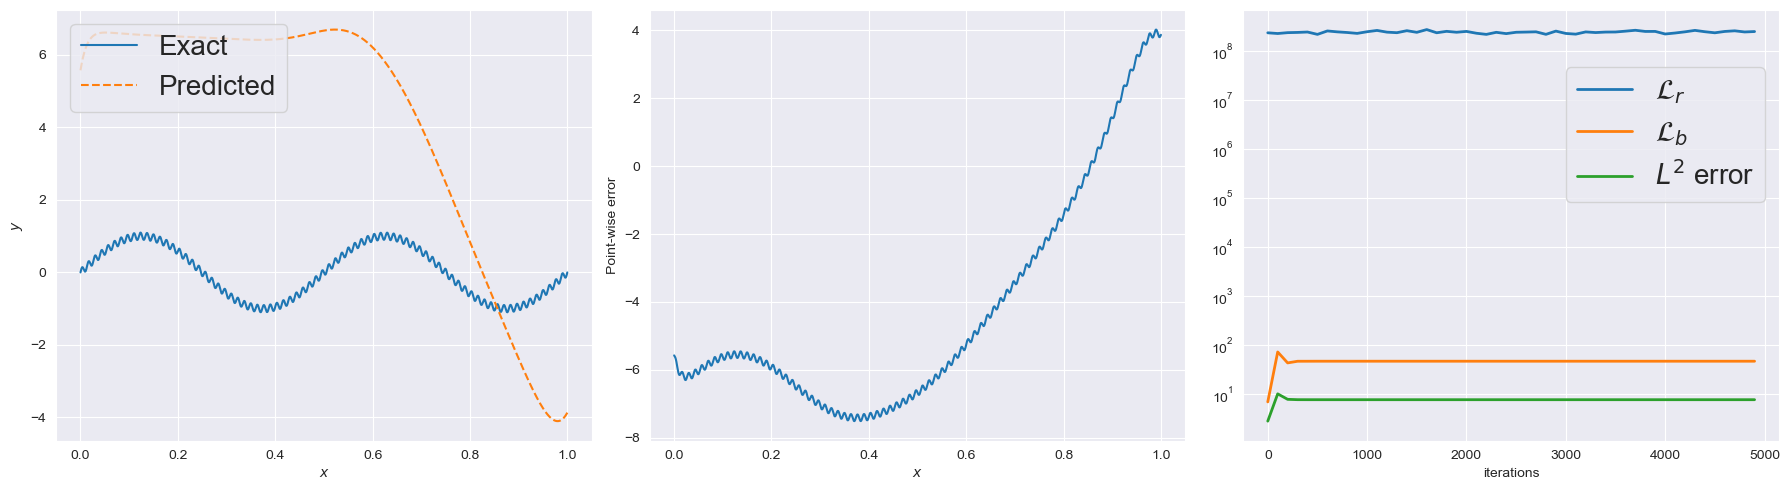

In [6]:
    # Plot
    fig = plt.figure(figsize=(18, 5))
    with sns.axes_style("darkgrid"):
        plt.subplot(1, 3, 1)
        plt.plot(X_star, u_star, label='Exact')
        plt.plot(X_star, u_pred, '--', label='Predicted')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.legend(fontsize=20, loc='upper left')
        plt.tight_layout()

        plt.subplot(1, 3, 2)
        plt.plot(X_star, u_star - u_pred, label='Error')
        plt.xlabel('$x$')
        plt.ylabel('Point-wise error')
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        plt.tight_layout()

        plt.subplot(1, 3, 3)
        iters = 100 * np.arange(len(loss_res))

        plt.plot(iters, loss_res, label='$\mathcal{L}_{r}$', linewidth=2)
        plt.plot(iters, loss_bcs, label='$\mathcal{L}_{b}$', linewidth=2)
        plt.plot(iters, l2_error, label=r'$L^2$ error', linewidth=2)

        plt.yscale('log')
        plt.xlabel('iterations')
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9), fontsize=20)
        plt.tight_layout()
        plt.show()

In [7]:
import scipy.io

In [8]:
scipy.io.savemat("1.mat", {'u': u_pred}) 